In [81]:
import numpy as np

In [82]:
import pandas as pd

In [83]:
df=pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [84]:
class SVM:

    def __init__(self, kernel="linear", C=1.0, gamma=1.0, degree=3, coef0=1.0, max_iter=1000):
        self.kernel_type = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.max_iter = max_iter
        self.loss_history = []


    def kernel(self, x, y):
        if self.kernel_type == "linear":
            return np.dot(x, y)
        elif self.kernel_type == "poly":
            return (self.gamma * np.dot(x, y) + self.coef0) ** self.degree
        elif self.kernel_type == "rbf":
            return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)
        else:
            raise ValueError("Unknown kernel")


    
    def compute_dual_loss(self):
        term1 = np.sum(self.alpha)
        term2 = 0.5 * np.sum(
            (self.alpha[:, None] * self.alpha[None, :] *
             self.Y[:, None] * self.Y[None, :] * self.K)
        )
        return term1 - term2


    def fit(self, X, Y):
        self.X = X
        self.Y = np.where(Y <= 0, -1, 1)

        m, n = X.shape
        self.alpha = np.zeros(m)
        self.b = 0

        #kernel matrix
        self.K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                self.K[i][j] = self.kernel(X[i], X[j])

        # Training loop
        for iter in range(self.max_iter):
            for i in range(m):

                # margin output
                f_i = np.sum(self.alpha * self.Y * self.K[:, i]) + self.b

                
                grad = 1 - self.Y[i] * f_i

                
                self.alpha[i] += self.C * grad

                #dual constraints: 0 ≤ alpha ≤ C
                self.alpha[i] = min(max(self.alpha[i], 0), self.C)

            # bias estimate 
            self.b = np.mean(self.Y - np.sum(self.alpha * self.Y * self.K, axis=0))

            #loss
            self.loss_history.append(self.compute_dual_loss())


    def predict(self, X_test):
        predictions = []
        for x in X_test:
            s = 0
            for alpha_i, y_i, x_i in zip(self.alpha, self.Y, self.X):
                if alpha_i > 1e-6:
                    s += alpha_i * y_i * self.kernel(x_i, x)
            s += self.b
            predictions.append(1 if s >= 0 else 0)
        return np.array(predictions)


In [85]:
def train_test_split(X, Y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    test_len = int(len(indices) * test_size)

    test_idx = indices[:test_len]
    train_idx = indices[test_len:]

    return X[train_idx], X[test_idx], Y[train_idx], Y[test_idx]


def standardize(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0) + 1e-8

    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std

    return X_train_std, X_test_std

In [86]:
df = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# encode Sex
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

# fill numeric missing values
df["Age"] = df["Age"].fillna(df["Age"].median())

# encode Embarked
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})


df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df = df.drop(["SibSp", "Parch"], axis=1)


Y = df["Survived"].values
X = df.drop("Survived", axis=1).values

print("Final shape:", X.shape)  


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


X_train, X_test = standardize(X_train, X_test)

Final shape: (891, 6)


In [87]:
import matplotlib.pyplot as plt

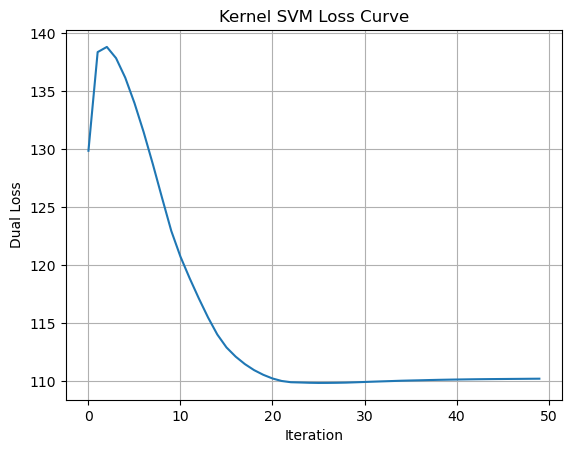

In [98]:
svm = SVM(kernel="rbf", C=0.5, gamma=0.5, max_iter=50)
svm.fit(X_train, Y_train)




plt.plot(svm.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Dual Loss")
plt.title("Kernel SVM Loss Curve")
plt.grid(True)
plt.show()


In [89]:
y_pred = svm.predict(X_test)
print("Accuracy:", np.mean(y_pred == Y_test))


Accuracy: 0.7528089887640449


In [90]:
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn


In [91]:
tp, tn, fp, fn = confusion_matrix(Y_test, y_pred)
print("TP:", tp, "TN:", tn, "FP:", fp, "FN:", fn)

TP: 53 TN: 81 FP: 24 FN: 20


In [92]:
precision = tp / (tp + fp + 1e-8)
print("Precision:", precision)

recall = tp / (tp + fn + 1e-8)
print("Recall:", recall)

f1 = 2 * precision * recall / (precision + recall + 1e-8)
print("F1 Score:", f1)

Precision: 0.6883116882222973
Recall: 0.7260273971608182
F1 Score: 0.7066666615760001


In [93]:
def pca_fit(X_train, n_components=None, variance_threshold=None):
    mean = X_train.mean(axis=0)
    Xc = X_train - mean
    cov = np.cov(Xc, rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    total_var = eigvals.sum()
    explained_ratio = eigvals / (total_var + 1e-12)
    cumulative = np.cumsum(explained_ratio)

    if variance_threshold is not None:
        k = np.searchsorted(cumulative, variance_threshold) + 1
    elif n_components is not None:
        k = n_components
    else:
        k = X_train.shape[1]

    return {
        "components": eigvecs[:, :k],
        "explained_ratio": explained_ratio,
        "cumulative": cumulative,
        "mean": mean,
        "k": k
    }

def pca_transform(X, pca_dict):
    Xc = X - pca_dict["mean"]
    return np.dot(Xc, pca_dict["components"])


def plot_scree(pca_dict, max_components=15):
    r = pca_dict["explained_ratio"]
    c = pca_dict["cumulative"]
    x = np.arange(1, len(r) + 1)

    plt.figure(figsize=(7,4))
    plt.bar(x[:max_components], r[:max_components], alpha=0.6, label="Explained Var")
    plt.plot(x[:max_components], c[:max_components], marker='o', label="Cumulative Var")
    plt.xlabel("Component")
    plt.ylabel("Variance Ratio")
    plt.title("Scree Plot")
    plt.grid(True)
    plt.legend()
    plt.show()


PCA components chosen: 5


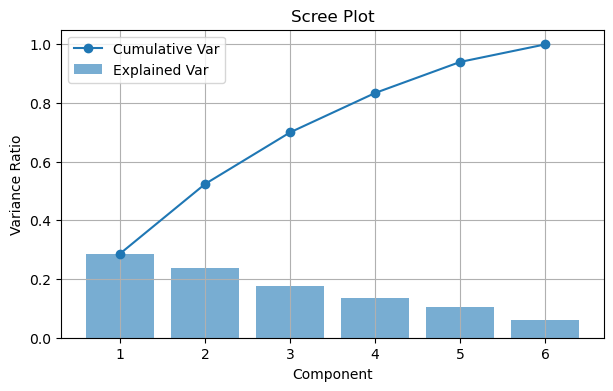

In [94]:

pca_info = pca_fit(X_train, n_components=5)

print("PCA components chosen:", pca_info["k"])

plot_scree(pca_info)  


In [95]:
X_train_pca = pca_transform(X_train, pca_info)
X_test_pca = pca_transform(X_test, pca_info)

print("Original shape:", X_train.shape)
print("PCA shape:", X_train_pca.shape)


Original shape: (713, 6)
PCA shape: (713, 5)


=== WITH PCA ===
Accuracy: 0.7584269662921348
Precision: 0.6973684209608726
Recall: 0.7260273971608182
F1 Score: 0.7114093908796901


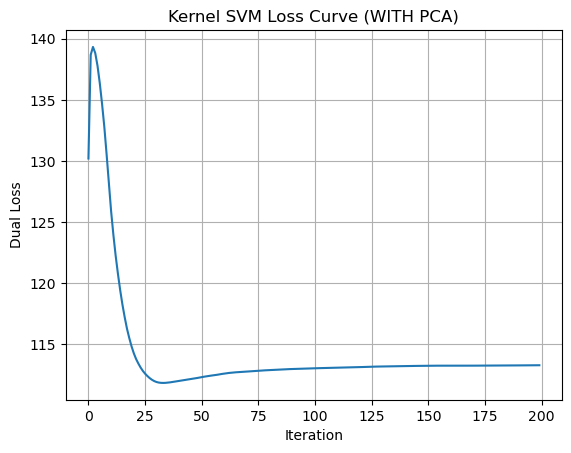

In [96]:

svm_pca = SVM(kernel="rbf", C=0.5, gamma=0.5, max_iter=200)
svm_pca.fit(X_train_pca, Y_train)

y_pred_pca = svm_pca.predict(X_test_pca)

# metrics
tp, tn, fp, fn = confusion_matrix(Y_test, y_pred_pca)

precision_pca = tp / (tp + fp + 1e-8)
recall_pca = tp / (tp + fn + 1e-8)
f1_pca = 2 * precision_pca * recall_pca / (precision_pca + recall_pca + 1e-8)
accuracy_pca = (tp + tn) / (tp + tn + fp + fn)

print(" WITH PCA ")
print("Accuracy:", accuracy_pca)
print("Precision:", precision_pca)
print("Recall:", recall_pca)
print("F1 Score:", f1_pca)

plt.plot(svm_pca.loss_history)
plt.title("Kernel SVM Loss Curve (WITH PCA)")
plt.xlabel("Iteration")
plt.ylabel("Dual Loss")
plt.grid(True)
plt.show()
